In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
import os
import cv2
from PIL import Image
import torchvision.transforms as transforms
import torch
import numpy as np
from skimage.util import random_noise
from skimage import img_as_ubyte
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from torchvision import models, transforms
from random import sample
from skimage import img_as_ubyte
from torch.utils.data import DataLoader


In [2]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/kaggle/input/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
94493,00024255_000.png,No Finding,0,24255,40,M,PA,2048,2500,0.168,0.168,NaN,/kaggle/input/data/images_010/images/00024255_...
20885,00005573_000.png,Infiltration,0,5573,8,M,PA,2048,2500,0.171,0.171,NaN,/kaggle/input/data/images_003/images/00005573_...
14676,00003825_000.png,No Finding,0,3825,44,F,PA,2048,2500,0.168,0.168,NaN,/kaggle/input/data/images_002/images/00003825_...


In [3]:
column_headers = ['No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia']
for header in column_headers:
    all_xray_df[header] = None
    
column_headers = all_xray_df['Finding Labels'].str.get_dummies(sep='|').columns

# Add columns for each unique column header and set initial values to 0
for header in column_headers:
    all_xray_df[header] = 0

# Set the respective column entry to 1 when the 'Finding Labels' string matches the column header
for index, row in all_xray_df.iterrows():
    findings = row['Finding Labels'].split('|')
    for finding in findings:
        if finding in column_headers:
            all_xray_df.at[index, finding] = 1
    
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Fibrosis,Hernia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,1,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,1,0,0,1,0,0,0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0


In [4]:
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: 'T' if x==1 else 'F')

all_xray_df[all_xray_df['pneumonia_class']=='T'].head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Fibrosis,Hernia,Pneumothorax,pneumonia_class
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,...,0,0,0,0,0,1,0,0,1,T
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,T
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,...,0,0,0,1,0,1,0,0,0,T
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,...,0,1,0,0,1,1,0,0,0,T
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,T


In [5]:
print(all_xray_df[all_xray_df['pneumonia_class']== 'T']['pneumonia_class'].count())
print(all_xray_df[all_xray_df['pneumonia_class']== 'F']['pneumonia_class'].count())

1431
110689


In [6]:
column_names = all_xray_df.columns.tolist()
print(column_names)

['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path', 'No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Hernia', 'Pneumothorax', 'pneumonia_class']


In [7]:
all_xray_df = all_xray_df.drop(columns=['Unnamed: 11'])

In [8]:
columns_with_none = all_xray_df.columns[all_xray_df.isna().any()]
columns_with_none

Index([], dtype='object')

In [9]:
def split_data(df, random_state=42):

    # Split the dataframe into training, validation, and testing sets
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=random_state)
    
    #index values of pneumonia
    
    p_inds = train_df[train_df.pneumonia_class=='T'].index.tolist()
    np_inds = train_df[train_df.pneumonia_class=='F'].index.tolist()
    
    np_sample = sample(np_inds,len(p_inds))
    train_data = train_df.loc[p_inds + np_sample]
    

    p_inds = val_df[val_df.pneumonia_class=='T'].index.tolist()
    np_inds = val_df[val_df.pneumonia_class=='F'].index.tolist()

    np_sample = sample(np_inds, len(p_inds))
    val_data = val_df.loc[p_inds + np_sample]
    
    return train_data, val_data

In [10]:
data_train, data_val = split_data(all_xray_df, random_state=42)

In [11]:
data_train[data_train['pneumonia_class']=='T']['pneumonia_class'].count()

1137

In [12]:
data_val[data_val['pneumonia_class']=='T']['pneumonia_class'].count()

294

In [13]:
columns_with_none = data_train.columns[data_train.isna().any()]

# Print the columns with None values
print("Columns with None values:")
print(columns_with_none)

Columns with None values:
Index([], dtype='object')


In [14]:
def apply_transforms(df, p=0.7):
    transform = transforms.Compose([
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    ])

    negative_images = df[df['pneumonia_class'] == 'F']
    transformed_df = pd.DataFrame(columns=df.columns)  # create a new DataFrame for transformed images

    transformed_images_count = 0
    skipped_images_count = 0

    for index, row in negative_images.iterrows():
        if np.random.rand() < p:
            img_path = row['path']
            try:
                image = Image.open(img_path).convert("RGB")
            except Exception as e:
                print(f"Couldn't open image: {img_path}. Skipping.")
                skipped_images_count += 1
                continue

            # Generate the new directory and filename for transformed image
            new_dir = os.path.join("/kaggle/working", "trans_" + os.path.dirname(img_path))  # Kaggle allows writing to /kaggle/working
            new_filename = "trans_" + os.path.basename(img_path)

            # Create the new directory if it doesn't exist
            os.makedirs(new_dir, exist_ok=True)

            # Save the transformed image to the new directory with the new filename
            transformed_image_path = os.path.join(new_dir, new_filename)
            transformed_image = transform(image)
            transformed_image.save(transformed_image_path)

            # Create a new row with the same data as the original, but update the 'Image Index' and 'path' columns
            new_row = row.copy()
            new_row['Image Index'] = new_filename
            new_row['path'] = transformed_image_path

            # Append the new row to the transformed DataFrame
            transformed_df = transformed_df.append(new_row, ignore_index=True)

            transformed_images_count += 1

            if transformed_images_count % 100 == 0:
                print(f"{transformed_images_count} images transformed.")

    print(f"Total transformed images: {transformed_images_count}")
    print(f"Total skipped images: {skipped_images_count}")
    
    return transformed_df  # return the new DataFrame



In [15]:
data_train = apply_transforms(data_train)

/tmp/ipykernel_117/575745742.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transformed_df = transformed_df.append(new_row, ignore_index=True)


100 images transformed.
200 images transformed.
300 images transformed.
400 images transformed.
500 images transformed.
600 images transformed.
700 images transformed.
Total transformed images: 788
Total skipped images: 0


In [16]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torch

class ChestXRayDataset(Dataset):
    def __init__(self, df):
        self.df = df.copy()  # Create a copy to not modify the original df
        self.df.reset_index(drop=True, inplace=True)
        self.df.drop(columns=['Patient Gender', 'View Position'], inplace=True)

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Change the resize dimensions to match EfficientNet-B4
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        self.label = 'pneumonia_class'  # Single label for binary classification

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx % len(self.df)]  # Handle out-of-range index
        img_path = row['path']
        img = Image.open(img_path).convert('RGB')  # convert image to RGB
        img = self.transform(img)

        # Map 'T' to 1.0 and 'F' to 0.0 before making a tensor
        label_map = {'T': 1.0, 'F': 0.0}
        label = torch.tensor(label_map[row[self.label]], dtype=torch.float32)

        return img, label

def prepare_datasets(data_train, data_val):
    train_dataset = ChestXRayDataset(data_train)
    val_dataset = ChestXRayDataset(data_val)

    return train_dataset, val_dataset


In [17]:
train_df, val_df = prepare_datasets(data_train, data_val)

In [18]:
batch_size = 32
train_dataloader = DataLoader(train_df, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_df, batch_size=batch_size, shuffle=False)

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def show_sample_images(df):
    # Select three random rows from the dataframe
    sample_df = df.sample(n=3)

    # Iterate over the selected rows
    for _, row in sample_df.iterrows():
        image_path = row['path']

        # Load and display the image
        image = Image.open(image_path)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        # Display the image with pixel axis
        ax1.imshow(image)
        ax1.set_title('Image')
        ax1.set_xticks([])
        ax1.set_yticks([])

        # Calculate normalized pixel intensity
        pixel_array = np.array(image.convert('L'))
        normalized_intensity, intensity_bins = np.histogram(pixel_array, bins=256, density=True)

        # Display the histogram of normalized pixel intensity
        ax2.bar(intensity_bins[:-1], normalized_intensity, width=1, color='gray')
        ax2.axvline(0.2 * 255, color='red', linestyle='--', label='Threshold')
        ax2.set_title('Normalized Pixel Intensity')
        ax2.set_xlabel('Pixel Intensity')
        ax2.set_ylabel('Frequency')
        ax2.legend()

        # Show the plot
        plt.show()



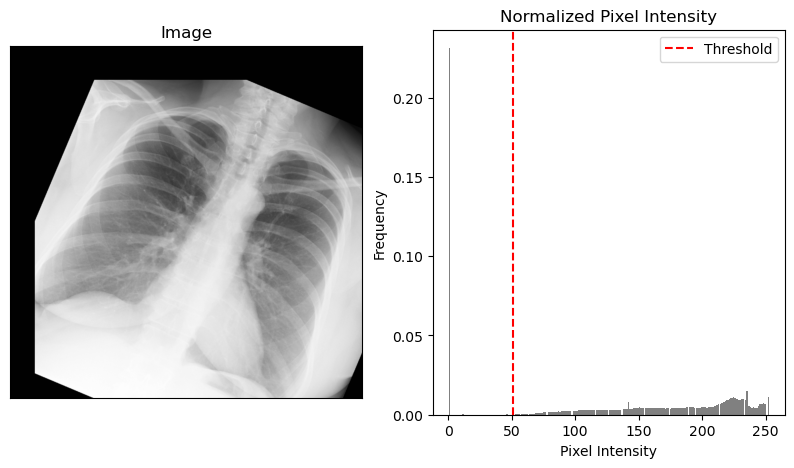

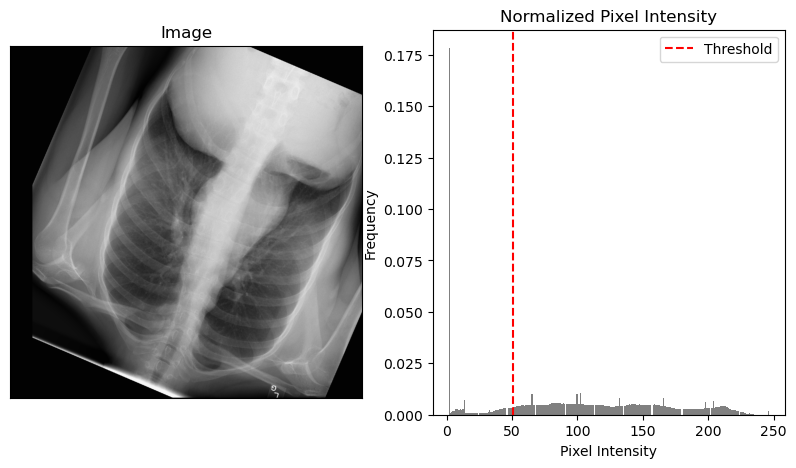

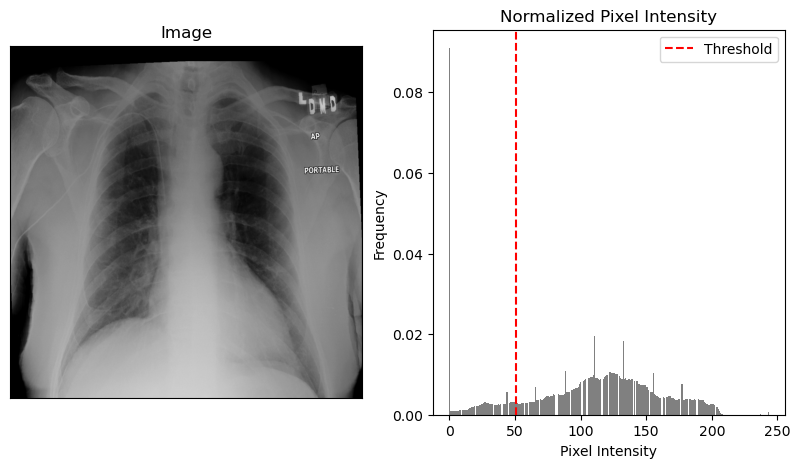

In [20]:
show_sample_images(data_train)

In [21]:
import torch
from torchvision import models, transforms
import torch.nn as nn

def load_pretrained_model():
    # Load the pre-trained VGG16 model
    model = models.vgg16(weights='IMAGENET1K_V1')
    
    # Removing classifier layers (i.e., 'include_top=False')
    model = nn.Sequential(*list(model.features.children()))
    
    # Freezing the first 14 layers
    for i, layer in enumerate(model.children()):
        if i < 14:
            for param in layer.parameters():
                param.requires_grad = False
    
    return model

In [22]:
def modify_model(model):
    # Freeze parameters so we don't backprop through them
    vgg_model = load_pretrained_model()
    
    # Define the new model
    my_model = nn.Sequential(
        vgg_model,
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(25088, 1024),  # VGG16 outputs 25088 features after the conv layers
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )
    return my_model

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
import torch.nn as nn
import torch.optim as optim

vgg_model = load_pretrained_model()

# Modify the model
model = modify_model(vgg_model)

# Define the optimizer and the loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import time
import copy

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    device = torch.device(device)
    model = model.to(device)

    train_loss_history = []
    val_loss_history = []
    all_labels = []
    all_outputs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.unsqueeze(1).to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).squeeze()
                    labels = labels.squeeze(dim=1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                all_labels.append(labels.detach().cpu().numpy())
                all_outputs.append(outputs.detach().cpu().numpy())

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)

    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)

    precision = precision_score(all_labels, all_outputs.round())
    recall = recall_score(all_labels, all_outputs.round())
    f1 = f1_score(all_labels, all_outputs.round())
    roc_auc = roc_auc_score(all_labels, all_outputs)

    print('Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, ROC AUC: {:.4f}'.format(
            precision, recall, f1, roc_auc))

    plot_loss_graphs(train_loss_history, val_loss_history)
    plot_metrics_graph(precision, recall, f1, roc_auc)

    return model


def plot_loss_graphs(train_loss_history, val_loss_history):
    plt.figure(figsize=(10,6))
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_metrics_graph(precision, recall, f1, roc_auc):
    metrics = [precision, recall, f1, roc_auc]
    labels = ['Precision', 'Recall', 'F1', 'ROC AUC']
    
    for i, metric in enumerate(metrics):
        plt.figure(figsize=(6,4))
        plt.bar(labels[i], metric)
        plt.ylim(0, 1)
        plt.xlabel('Metric')
        plt.ylabel('Score')
        plt.title(labels[i])
        plt.show()


In [29]:
print("Device:", device)

Device: cuda


Epoch 0/4
----------
train Loss: 0.0295
val Loss: 50.0000
Epoch 1/4
----------
train Loss: 0.0000
val Loss: 50.0000
Epoch 2/4
----------
train Loss: 0.0000
val Loss: 50.0000
Epoch 3/4
----------
train Loss: 0.0000
val Loss: 50.0000
Epoch 4/4
----------
train Loss: 0.0000
val Loss: 50.0000
Training complete in 3m 44s
Best val Loss: 50.000000
Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC AUC: 0.4970


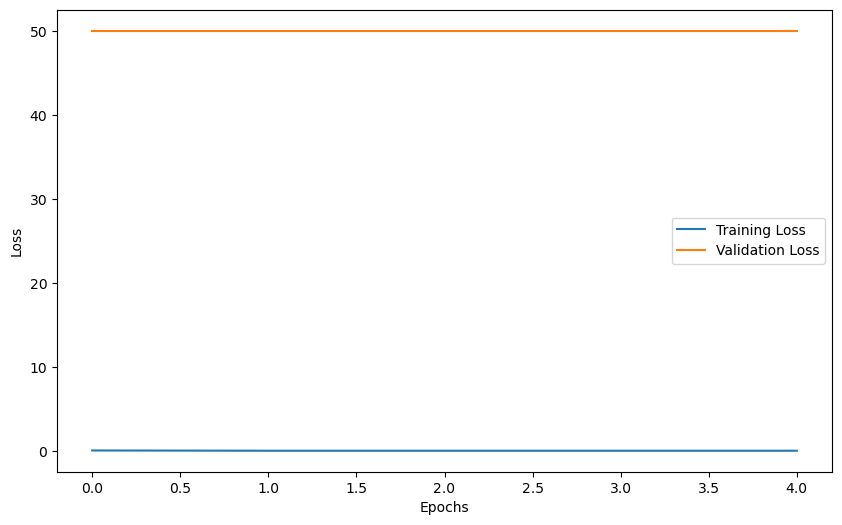

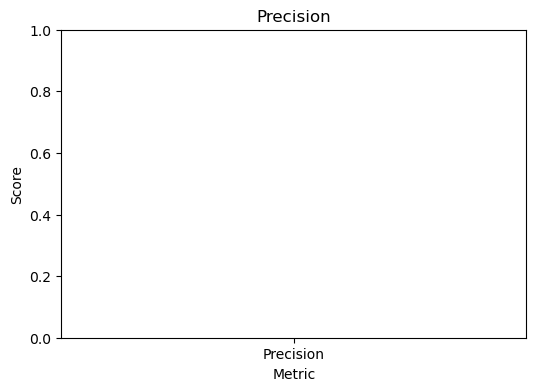

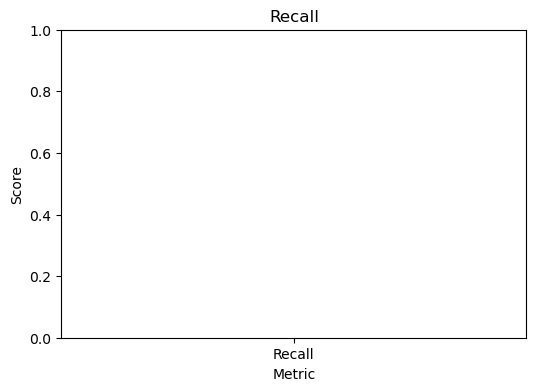

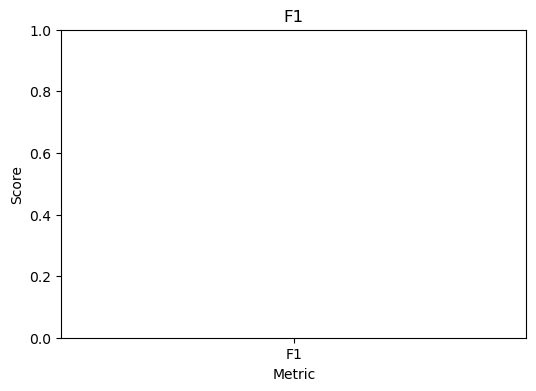

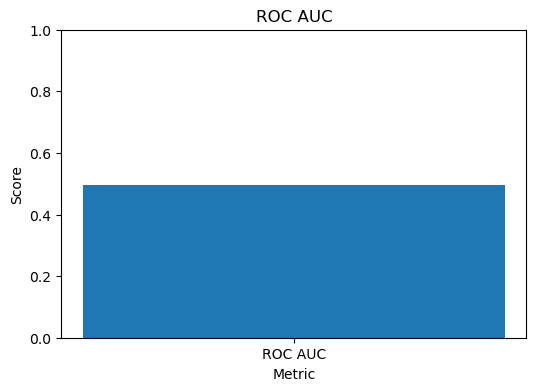

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=5, device='cuda')